# Support Vector Machine

In [9]:
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay


In [10]:
# Load Data
X_train_input = joblib.load("Data/Xtrain1.pkl")
Y_train_input = np.load('Data/Ytrain1.npy')

print(X_train_input.shape)
print(Y_train_input.shape)

(700, 2)
(700,)


In [11]:
# Extract patient IDs
patient_ids = X_train_input["Patient_Id"].values

# Split into train/test (patients 1–3 for test)
mask_test = np.isin(patient_ids, [1, 2, 3])
mask_train = ~np.isin(patient_ids, [1, 2, 3])

X_train_df = X_train_input[mask_train]
Y_train = Y_train_input[mask_train]

X_test_df = X_train_input[mask_test]
Y_test = Y_train_input[mask_test]

# Extract feature arrays
X_train = np.vstack(X_train_df["Skeleton_Features"].values)
X_test = np.vstack(X_test_df["Skeleton_Features"].values)


In [12]:
# Get train groups
groups_train = X_train_df["Patient_Id"].values 

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# Define SVM Model and Hyperparameter Grid 
svm = SVC(probability=False, random_state=42)

param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.5, 1, 2, 3],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3]  # Only used if kernel='poly'
}

cv = LeaveOneGroupOut()

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=cv.split(X_train_scaled, Y_train, groups=groups_train),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)


In [14]:
# Hyperparameter Cross-Validation 
print("\nRunning grid search for SVM...")
grid_search.fit(X_train_scaled, Y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best CV F1-macro: {grid_search.best_score_:.4f}")


Running grid search for SVM...
Fitting 11 folds for each of 48 candidates, totalling 528 fits
[CV] END ........C=0.5, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.5, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.5, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.5, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.5, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.5, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.5, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.5, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.5, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.5, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...........C=0.5, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....

In [15]:
# Evaluate on Test Set 
best_model = grid_search.best_estimator_

Y_pred = best_model.predict(X_test_scaled)
f1 = f1_score(Y_test, Y_pred, average='macro')

print(f"\nTest F1-score (macro): {f1:.4f}")


Test F1-score (macro): 0.8210


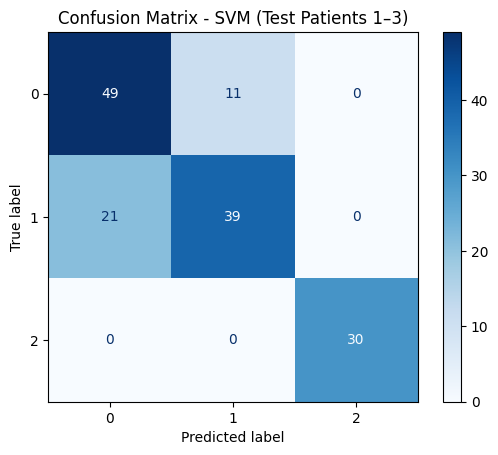

In [16]:
# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - SVM (Test Patients 1–3)")
plt.show()